# **Setup**

## Libraries and Notebook Settings

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Standard notebook libraries
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import pandas as pd
import numpy as np
import os

# Visualizations libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')

# Libraries to support model building
from scipy.stats import pearsonr
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Library to support model analysis
import shap

# Google Drive functionality
from google.colab import drive
drive.mount('/content/drive')

clear_output()

## Google Drive OR Local

In [3]:
drive = True
local = not drive

### Data Read

In [4]:
# Path Definition
if drive:
  path = 'drive/MyDrive/Projects/wave/'
else:
  os.chdir('/Users/adisrikanth/Documents/Projects/DataProjects/waimea-wave-data')
  path = ''

# Data reads
data_wide = pd.read_csv(path + 'data/wide.csv')
data_b = pd.read_csv(path + 'data/buoy-data.csv')

# **Exploratory Data Analysis**

## Buoy Data CSV

In [5]:
data_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14610 entries, 0 to 14609
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   station_id            14610 non-null  object 
 1   station_name          14610 non-null  object 
 2   date                  14610 non-null  object 
 3   air_temp              5686 non-null   float64
 4   average_wave_period   8128 non-null   float64
 5   dominant_wave_period  8506 non-null   float64
 6   wave_height           12359 non-null  float64
dtypes: float64(4), object(3)
memory usage: 799.1+ KB


### Map ID to Location

In [6]:
id_to_name_df = data_b[['station_id', 'station_name']].drop_duplicates()
id_to_name = dict(zip(id_to_name_df.station_id, id_to_name_df.station_name))
id_to_name

{'21418t': 'North Tokyo',
 '46402t': 'Dutch Harbor Alaska',
 '51000h': 'Northern Hawaii One',
 '51101h': 'Northwestern Hawaii Two',
 '51201h': 'Waimea Bay'}

## Wide CSV

In [7]:
data_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         2922 non-null   object 
 1   air_temp_51000h              2860 non-null   float64
 2   air_temp_51101h              2826 non-null   float64
 3   average_wave_period_51000h   2451 non-null   float64
 4   average_wave_period_51101h   2826 non-null   float64
 5   average_wave_period_51201h   2851 non-null   float64
 6   dominant_wave_period_51000h  2829 non-null   float64
 7   dominant_wave_period_51101h  2826 non-null   float64
 8   dominant_wave_period_51201h  2851 non-null   float64
 9   wave_height_21418t           1223 non-null   float64
 10  wave_height_46402t           2630 non-null   float64
 11  wave_height_51000h           2829 non-null   float64
 12  wave_height_51101h           2826 non-null   float64
 13  wave_height_51201h

### Pre Processing

In [8]:
# Rename Columns
data_wide = data_wide.rename(columns = {'wave_height_51201h': 'wave_height_bay',
                                        'dominant_wave_period_51201h': 'dominant_wave_period_bay',
                                        'average_wave_period_51201h': 'average_wave_period_bay',
                                        'air_temp_51000h' : 'air_temp_north',
                                        'average_wave_period_51000h': 'average_wave_period_north',
                                        'dominant_wave_period_51000h': 'dominant_wave_period_north',
                                        'wave_height_51000h': 'wave_height_north',
                                        'air_temp_51101h': 'air_temp_nw',
                                        'average_wave_period_51101h': 'average_wave_period_nw',
                                        'dominant_wave_period_51101h': 'dominant_wave_period_nw',
                                        'wave_height_51101h': 'wave_height_nw',
                                        'wave_height_21418t' : 'wave_height_tokyo',
                                        'wave_height_46402t' : 'wave_height_alaska'})

In [9]:
# Extract Year and Month from Date
# Note: both of these features should be treated as categorical variables (additional note on this later)

data_wide['year'] = pd.DatetimeIndex(data_wide['date']).year
data_wide['month'] = pd.DatetimeIndex(data_wide['date']).month

### Target Variable Analysis

In [10]:
# Plot distribution of target variable

def plot_feature(df, feature_name):
    df[feature_name].hist(bins = 50)
    plt.title('Distribution of ' + feature_name)
    plt.show()

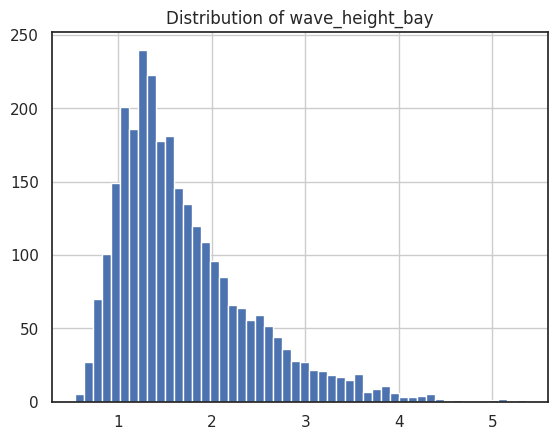

In [11]:
plot_feature(data_wide, 'wave_height_bay')

### Missing Data

We notice that generally speaking, when a beacon is down, it does not send any data points. As in, it is not standard for a beacon to send one metric but not send another. As such, we consider missing data grouped by beacon.

In [12]:
# Null Columns vs Non Null Columns by Feature

null_analysis_dict = {}
for col in data_wide.columns:
    nulls = data_wide[data_wide[col].isnull()]
    non_nulls = data_wide[data_wide[col].notnull()]

    analysis_df = nulls.describe().join(non_nulls.describe(), lsuffix = '_null', rsuffix = '_non_null').T.reset_index()
    null_analysis_dict[col] = analysis_df

For each feature, we separate data into two groups: data that exists when the feature is null and data that exists when the feature is non null. Then, for each feature, we compare the distributions of the two datasets. We pay closest attention to the wave height in Waimea Bay as it is our target variable and we also pay special attention to the median values instead of the mean (because we have not yet pulled out outliers).

We find the following trends for our features:

- north hawaii beacon:  significant difference
- nw hawaii beacon:  significant difference
- tokyo beacon:  insignificant difference
- alaska beacon:  insignificant difference

Essentially, the status of the hawaii beacons _may_ be indicative of environmental conditions or other factors that carry correlation with our target variable (wave height at the bay). So, in these cases, we code these variables are categorical in order to allow for a separate category for missing data.

In the cases of the tokyo and alaska beacon, there seems to be very little difference in other features when these beacons are on/off. As such, we do not believe that the missing data points are indicative of any trend. In this case, we choose the simpler route of imputing the datapoints using the median of the columns. We do not consider dropping rows as data points given the limited size of our dataset. However, with more data, this calculus could be different.

In [13]:
# Sample Output
null_analysis_dict['wave_height_alaska'].sort_values(by = 'index')

,index,count,mean,std,min,25%,50%,75%,max
15,air_temp_north_non_null,2568.0,22.786559,2.460016,11.416667,21.940774,23.306250,24.358967,28.156522
0,air_temp_north_null,292.0,22.365751,1.092447,18.900000,21.683333,22.589583,23.113542,26.756522
16,air_temp_nw_non_null,2534.0,23.947010,1.843202,17.569565,22.700000,24.231250,25.355208,27.870833
1,air_temp_nw_null,292.0,22.818402,1.714286,17.841667,21.603125,23.243750,24.347917,25.169565
19,average_wave_period_bay_non_null,2582.0,7.150753,1.924966,3.926957,5.590312,6.817148,8.415729,14.220000
4,average_wave_period_bay_null,269.0,6.638768,1.707350,4.554681,5.474468,6.067234,7.138085,13.555581
17,average_wave_period_north_non_null,2209.0,9.207095,5.059251,4.950000,6.281250,7.191250,9.625000,29.883913
2,average_wave_period_north_null,242.0,10.129305,6.156970,5.152083,6.162708,7.361250,10.581875,29.980417
18,average_wave_period_nw_non_null,2534.0,7.017658,1.272557,4.633333,6.048125,6.728958,7.710938,13.058750
3,average_wave_period_nw_null,292.0,6.959239,1.299675,5.275833,6.132500,6.552330,7.335104,12.850833


### Correlation Analysis

In [14]:
# Note: these are linear relationships, we expect that we might see some non-linear relationships
data_wide.corr()

,air_temp_north,air_temp_nw,average_wave_period_north,average_wave_period_nw,average_wave_period_bay,dominant_wave_period_north,dominant_wave_period_nw,dominant_wave_period_bay,wave_height_tokyo,wave_height_alaska,wave_height_north,wave_height_nw,wave_height_bay,year,month
air_temp_north,1.000000,0.667591,-0.308917,-0.197686,-0.225944,-0.337122,-0.212301,-0.258550,-0.146068,0.305434,-0.321588,-0.237822,-0.324906,0.064282,0.419063
air_temp_nw,0.667591,1.000000,-0.212003,-0.423096,-0.467939,-0.195827,-0.380906,-0.458614,-0.051005,0.030426,-0.167423,-0.502542,-0.564448,0.061437,0.566125
average_wave_period_north,-0.308917,-0.212003,1.000000,0.126913,0.122192,0.955655,0.133831,0.115729,0.131299,-0.043722,0.983080,0.107699,0.116017,-0.191376,-0.100037
average_wave_period_nw,-0.197686,-0.423096,0.126913,1.000000,0.850864,0.032589,0.809565,0.784657,0.237806,0.072454,-0.043401,0.662646,0.634278,0.061624,-0.192458
average_wave_period_bay,-0.225944,-0.467939,0.122192,0.850864,1.000000,0.042933,0.732470,0.848551,0.250329,0.081844,-0.036937,0.650881,0.724458,0.075819,-0.189152
dominant_wave_period_north,-0.337122,-0.195827,0.955655,0.032589,0.042933,1.000000,0.087942,0.054341,0.109430,0.030161,0.991703,0.114199,0.124579,-0.078048,-0.168450
dominant_wave_period_nw,-0.212301,-0.380906,0.133831,0.809565,0.732470,0.087942,1.000000,0.816445,0.200829,0.074464,-0.001189,0.509419,0.507725,0.064654,-0.182130
dominant_wave_period_bay,-0.258550,-0.458614,0.115729,0.784657,0.848551,0.054341,0.816445,1.000000,0.241090,0.036949,-0.032991,0.568164,0.602415,0.038516,-0.175097
wave_height_tokyo,-0.146068,-0.051005,0.131299,0.237806,0.250329,0.109430,0.200829,0.241090,1.000000,0.542984,0.087176,0.215168,0.229209,0.838909,0.244510
wave_height_alaska,0.305434,0.030426,-0.043722,0.072454,0.081844,0.030161,0.074464,0.036949,0.542984,1.000000,0.026985,0.104035,0.129950,0.724372,0.015391


# **Feature Engineering**

In [15]:
full_feature_list = list(data_wide.columns)

full_feature_list.remove('date')
full_feature_list.remove('wave_height_bay')

target_variable = 'wave_height_bay'

## Imputing Data

In [16]:
# Imputing Missing Data with Median Value
data_wide['wave_height_tokyo'] = data_wide['wave_height_tokyo'].fillna(data_wide['wave_height_tokyo'].median())
data_wide['wave_height_alaska'] = data_wide['wave_height_alaska'].fillna(data_wide['wave_height_alaska'].median())

## Categorizing Features

In [17]:
# We take the numeric variables and turn them into categorical variables by quantile
hawaii_beacons = ['air_temp_north', 'average_wave_period_north', 'dominant_wave_period_north','wave_height_north',
                  'air_temp_nw', 'average_wave_period_nw', 'wave_height_nw', 'dominant_wave_period_nw']

def label_quintiles(df, feature_name):
    df[feature_name + '_quantile'] = pd.qcut(df[feature_name], 5, labels = False)
    df[feature_name + '_quantile'] = df[feature_name + '_quantile'] + 1
    return df

In [18]:
# If a data point is missing, we make the quantile for that data point negative one
for feature in hawaii_beacons:
    data_wide = label_quintiles(data_wide, feature)
    data_wide[feature + '_quantile'] = np.where(data_wide[feature].isnull(), -1, data_wide[feature + '_quantile'])
    full_feature_list.remove(feature)
    full_feature_list.append(feature + '_quantile')

## Target Variable Engineering

### Categorization

In [19]:
data_wide[target_variable + '_cat'] = np.where(data_wide[target_variable] >= 3, 1, 0)
data_wide[target_variable + '_cat'].value_counts()

0    2745
1     177
Name: wave_height_bay_cat, dtype: int64

### Dropping Null Values (for target variable only)

_NOTE: New DF Name_

In [20]:
model_df = data_wide[data_wide.wave_height_bay.notnull()]

### New Target Variable

In [21]:
target_variable = 'wave_height_bay_cat'

# **Model Implementation**

## Feature Prep

In [22]:
# We want to make these categorical (as intended), but xgboost via sklearn does not support categorical variables at this time
# XGBoost implemented via Spark does, but for prototyping, we use sklearn for speed

'''
model_df['air_temp_north_quantile'] = model_df['air_temp_north_quantile'].astype("str")
model_df['average_wave_period_north_quantile'] = model_df['average_wave_period_north_quantile'].astype("str")
model_df['dominant_wave_period_north_quantile'] = model_df['dominant_wave_period_north_quantile'].astype("str")
model_df['wave_height_north_quantile'] = model_df['wave_height_north_quantile'].astype("str")
model_df['air_temp_nw_quantile'] = model_df['air_temp_nw_quantile'].astype("str")
model_df['average_wave_period_nw_quantile'] = model_df['average_wave_period_nw_quantile'].astype("str")
model_df['wave_height_nw_quantile'] = model_df['wave_height_nw_quantile'].astype("str")
model_df['dominant_wave_period_nw_quantile'] = model_df['dominant_wave_period_nw_quantile'].astype("str")
'''

'\nmodel_df[\'air_temp_north_quantile\'] = model_df[\'air_temp_north_quantile\'].astype("str")\nmodel_df[\'average_wave_period_north_quantile\'] = model_df[\'average_wave_period_north_quantile\'].astype("str")\nmodel_df[\'dominant_wave_period_north_quantile\'] = model_df[\'dominant_wave_period_north_quantile\'].astype("str")\nmodel_df[\'wave_height_north_quantile\'] = model_df[\'wave_height_north_quantile\'].astype("str")\nmodel_df[\'air_temp_nw_quantile\'] = model_df[\'air_temp_nw_quantile\'].astype("str")\nmodel_df[\'average_wave_period_nw_quantile\'] = model_df[\'average_wave_period_nw_quantile\'].astype("str")\nmodel_df[\'wave_height_nw_quantile\'] = model_df[\'wave_height_nw_quantile\'].astype("str")\nmodel_df[\'dominant_wave_period_nw_quantile\'] = model_df[\'dominant_wave_period_nw_quantile\'].astype("str")\n'

## Model Implementation - Current Conditions

_NOTE: for an initial attempt, our model identifies the relationship between current conditions and current wave height. Ultimately we want to adapt this model to identify the relationship between current conditions and **future** wave height_

In [33]:
# Shuffle dataframe
model_df = model_df.sample(frac=1)

# Initial data and model
X = model_df[full_feature_list]
y = model_df[target_variable]

xgb_model = xgb.XGBClassifier(n_estimators = 1000,
                              objective="binary:logitraw",
                              max_depth = 5)

In [34]:
# Train model with three fold Cross Validation
precisions = cross_val_score(xgb_model, X, y, scoring = 'precision', cv = 3)

precisions.mean()

0.7112696734789759

## Model Analysis - Current Conditions

In [25]:
X['year'] = X['year'].astype('float')
X['month'] = X['month'].astype('float')

xgb_model.fit(X, y)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap_means = np.mean(shap_values, axis=0)

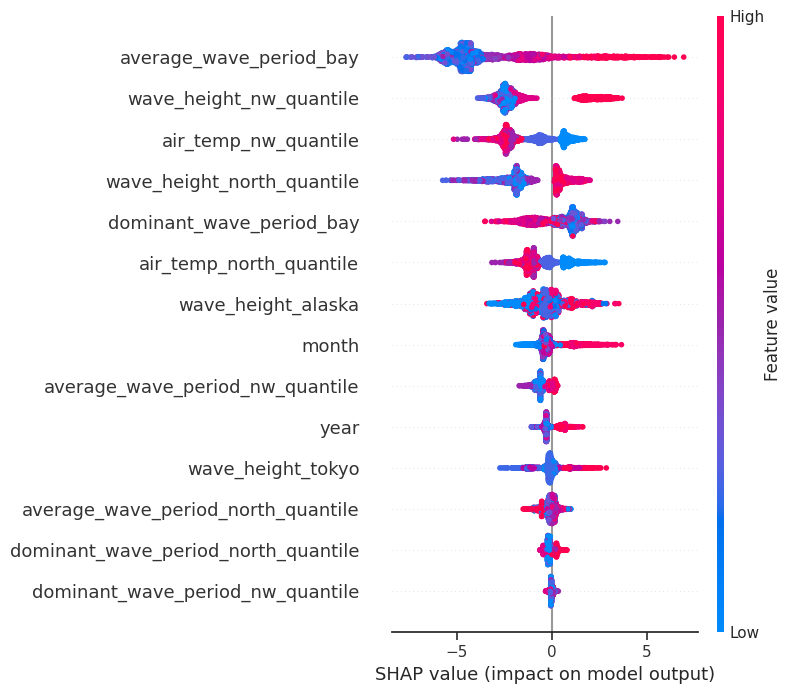

In [26]:
shap.summary_plot(shap_values, X)

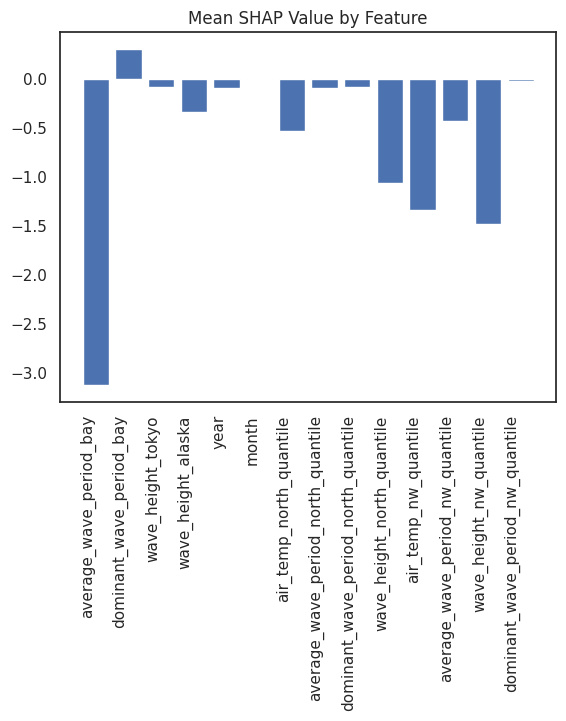

In [27]:
plt.bar(list(X.columns), shap_means)
plt.xticks(rotation=90, ha='right')
plt.title('Mean SHAP Value by Feature')
plt.show()

# **Environment Tidy Up**

In [28]:
!pip freeze > requirements.txt